In [1]:
import torch
from torch import nn 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm 
from torch.optim import AdamW, Adagrad, RMSprop
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
root_dir = "/kaggle/input/apc-tank-ifv/dataset"
dataset = datasets.ImageFolder(root_dir, transform=None)

In [78]:
classes = dataset.classes

In [7]:
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor()
    ])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])

In [9]:
class CustomTransform(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]

        if self.transform:
            x = self.transform(x)
        return x, y 


        

In [10]:
train_data = CustomTransform(train_set, transform = train_transform)
test_data = CustomTransform(test_set, transform = test_transform)
val_data = CustomTransform(val_set, transform = val_transform)

In [51]:
def output(limit, data):
    classes = ['apc', 'ifv', 'tank']
    count = 0
    for x, y in data:
        x = x.permute(1, 2, 0)
        
        plt.imshow(x)
        plt.title(classes[int(y)])
        plt.show()

        count += 1
        if count >= limit:
            break
    

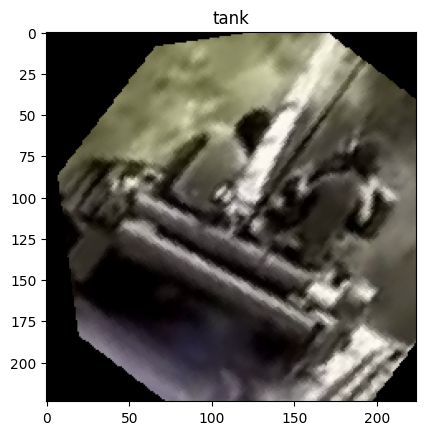

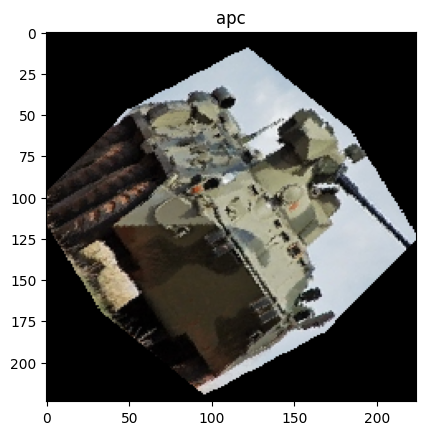

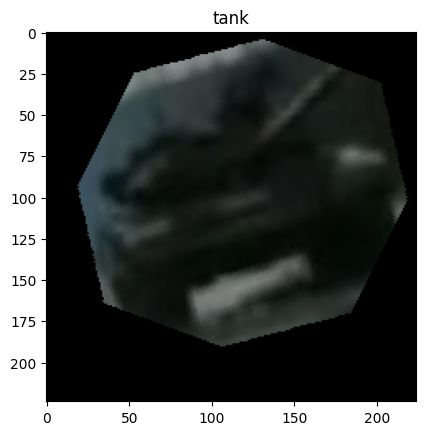

In [52]:
output(3, train_data)

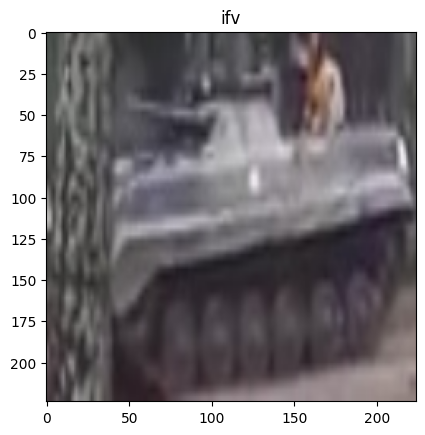

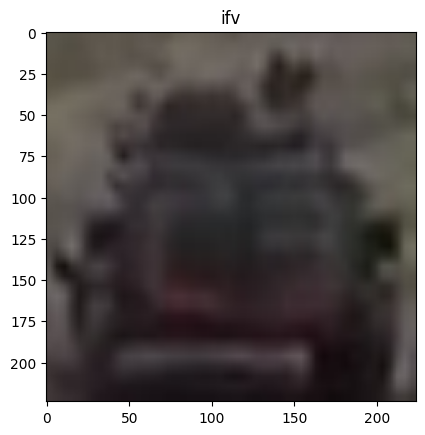

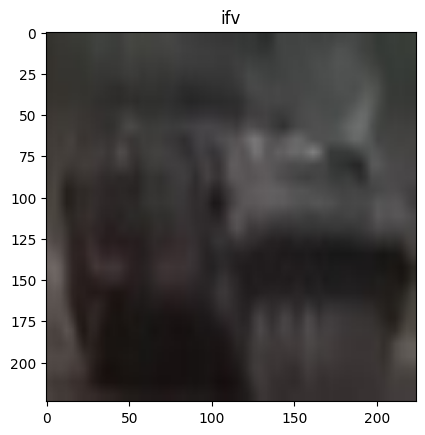

In [53]:
output(3, test_data)

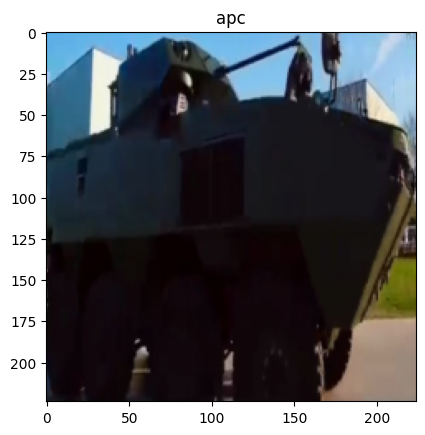

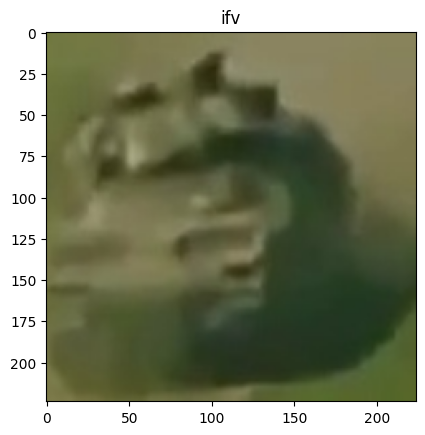

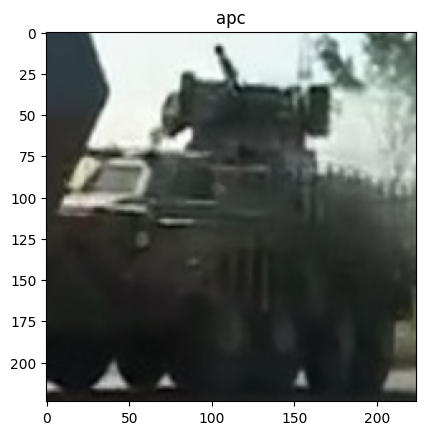

In [14]:
output(3, val_data)

In [15]:
batch_size = 128

train_dl = DataLoader(train_data, batch_size = batch_size, generator = torch.Generator(device="cpu"))
val_dl = DataLoader(val_data, batch_size = batch_size, generator = torch.Generator(device="cpu"))

In [16]:
len(train_dl)

96

In [ ]:
# def train(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs, device)

In [18]:
class SkipBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool = True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size=3, padding=1)

        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            self.pool = None

        self.add_conv = nn.Sequential()

        if in_channels != out_channels:
            self.add_conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=3, padding = 1)

    def forward(self, x):
        out = self.conv1(x)
        add_out = self.add_conv(x)

        # out = F.relu(out)

        out = self.conv2(out)

        out += add_out

        out = F.relu(out)

        if self.pool:
            out = self.pool(out)

        return out        

In [19]:
tensor = torch.rand(3, 224, 224)

layer1 = SkipBlock(3, 32)
layer2 = SkipBlock(32, 64)


In [20]:
out = layer1(tensor)
out = layer2(out)
out.shape

torch.Size([64, 56, 56])

In [21]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()

        self.conv = nn.Conv2d(in_channels = in_channels, out_channels=growth_rate, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv(x)
        out = F.relu(out)

        fin_out = torch.concat([x, out], dim = 1)

        return fin_out
        

In [22]:
block1 = DenseLayer(16, 16)
block2 = DenseLayer(32, 16)

In [23]:
tensor = torch.rand(1, 16, 224, 224)

out = block1(tensor)
out = block2(out)
out.shape

torch.Size([1, 48, 224, 224])

In [24]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers, pool = True):
        super().__init__()

        self.num_layers = num_layers

        self.layers = nn.ModuleList()

        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            self.pool = None 

        for i in range(self.num_layers):
            self.layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

            if self.pool:
                x = self.pool(x)

        return x
       

In [25]:
block1 = DenseBlock(3, 16, num_layers = 3)
block2 = DenseBlock(51, 16, num_layers = 3, pool = False)

tensor = torch.rand(1, 3, 224, 224)

In [26]:
out = block1(tensor)
out = block2(out)
out.shape

torch.Size([1, 99, 28, 28])

In [114]:
class Oko(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()

        self.skip_block1 = SkipBlock(3, 32)
        
        self.dense_block2 = DenseBlock(32, 16, num_layers=4)

        self.dense_block3 = DenseBlock(96, 16, num_layers=3, pool = False)

        self.dense_block4 = DenseBlock(144, 16, num_layers=1, pool = True)

    # 160

        self.skip_block5 = SkipBlock(160, 256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size = 3, padding = 1)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(1024, 256)
        self.drop = nn.Dropout(0.2)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, num_classes)
        

    def forward(self, x):
        out = self.skip_block1(x)

        out = self.dense_block2(out)
        out = self.dense_block3(out)
        out = self.dense_block4(out)
        out = self.skip_block5(out)
        out = self.conv5(out)
        out = F.relu(out)
        out = self.conv6(out)
        

        out = self.flatten(out)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.linear2(out)
        out = F.relu(out)
        res = self.linear3(out)

        return res 

    def predict(self, x):
        out = None 
        self.eval()

        with torch.no_grad():
            
            if len(x.shape) == 4:
                x = x.to(device)
                out = self.forward(x)
                
            if len(x.shape) == 3:
                x = x.unsqueeze(0).to(device)
                out = self.forward(x)


            
            t_res = torch.softmax(out, dim = 1)
            res = torch.argmax(t_res, dim = 1)
            return res
        
        

In [28]:
!pip install torchsummary 

In [115]:
from torchsummary import summary 

In [116]:
model = Oko()
model.to(device)

Oko(
  (skip_block1): SkipBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (add_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (dense_block2): DenseBlock(
    (layers): ModuleList(
      (0): DenseLayer(
        (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): DenseLayer(
        (conv): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): DenseLayer(
        (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): DenseLayer(
        (conv): Conv2d(80, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_block3): DenseBlock(
   

In [117]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]             896
            Conv2d-3         [-1, 32, 224, 224]           9,248
         MaxPool2d-4         [-1, 32, 112, 112]               0
         SkipBlock-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 16, 112, 112]           4,624
        DenseLayer-7         [-1, 48, 112, 112]               0
         MaxPool2d-8           [-1, 48, 56, 56]               0
            Conv2d-9           [-1, 16, 56, 56]           6,928
       DenseLayer-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 16, 28, 28]           9,232
       DenseLayer-13           [-1, 80, 28, 28]               0
        MaxPool2d-14           [-1, 80,

In [118]:
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        
        model.train()
        total_train_loss = 0.0
        total_train_labels = []
        total_train_preds = []

        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            outputs = model(x)

            loss = loss_fn(outputs, y)
    
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            total_train_labels.extend(y.cpu().numpy())
            total_train_preds.extend(preds.cpu().numpy())
            


        total_train_loss /= len(train_dl)
        train_acc = accuracy_score(total_train_labels, total_train_preds)

        model.eval()
        total_val_loss = 0.0
        total_val_labels = []
        total_val_preds = []

        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)

                outputs = model(x)
                val_loss = loss_fn(outputs, y)
                total_val_loss += val_loss.item()

                preds = torch.argmax(outputs, dim=1)
                total_val_preds.extend(preds.cpu().numpy())
                total_val_labels.extend(y.cpu().numpy())

        total_val_loss /= len(val_dl)
        val_acc = accuracy_score(total_val_preds, total_val_labels)

        history["train_loss"].append(total_train_loss)
        history["train_acc"].append(train_acc)

        history["val_loss"].append(total_val_loss)
        history["val_acc"].append(val_acc)

        print(f'Epoch: {epoch+1}; Loss: {total_train_loss:.4f}; Accuracy: {train_acc:.4f}; Val_loss: {total_val_loss:.4f}; Val_acc: {val_acc:.4f}')
    
    return history
        

In [57]:
# def train(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs, device):
#     history = {
#         "train_loss": [],
#         "train_accuracy": [],
#         "val_loss": [],
#         "val_accuracy": []
#     }

#     for epoch in range(epochs):
#         model.train()  
#         train_loss = 0.0  
#         all_train_labels = []
#         all_train_preds = []

#         for inputs, labels in tqdm(train_dataloader):
#             inputs, labels = inputs.to(device), labels.to(device)
            

#             optimizer.zero_grad()
            
#             outputs = model(inputs)
        
#             loss = loss_function(outputs, labels)
            
          
#             loss.backward()
            
   
#             optimizer.step()         
#             train_loss += loss.item()

            
#             _, predicted = torch.max(outputs, 1) 
#             all_train_preds.extend(predicted.cpu().numpy())
#             all_train_labels.extend(labels.cpu().numpy())

      
#         train_loss /= len(train_dataloader)
#         train_accuracy = accuracy_score(all_train_labels, all_train_preds)

#         model.eval()  
#         val_loss = 0.0  
#         all_val_labels = []
#         all_val_preds = []

#         with torch.no_grad():  
#             for inputs, labels in tqdm(val_dataloader):
#                 inputs, labels = inputs.to(device), labels.to(device)
                
#                 outputs = model(inputs)
#                 loss = loss_function(outputs, labels)
#                 val_loss += loss.item()


#                 _, predicted = torch.max(outputs, 1)  
#                 all_val_preds.extend(predicted.cpu().numpy())
#                 all_val_labels.extend(labels.cpu().numpy())


#         val_loss /= len(val_dataloader)
#         val_accuracy = accuracy_score(all_val_labels, all_val_preds)

   
#         print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
#               f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

 
#         history["train_loss"].append(train_loss)
#         history["train_accuracy"].append(train_accuracy)
#         history["val_loss"].append(val_loss)
#         history["val_accuracy"].append(val_accuracy)

#     return history


In [119]:
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [120]:
history = train(model, train_dl, val_dl, optimizer,loss_fn, 20, device)

100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 1; Loss: 0.9425; Accuracy: 0.5120; Val_loss: 0.8238; Val_acc: 0.6319


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 2; Loss: 0.7239; Accuracy: 0.6793; Val_loss: 0.6331; Val_acc: 0.7467


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch: 3; Loss: 0.5547; Accuracy: 0.7806; Val_loss: 0.4695; Val_acc: 0.8623


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 4; Loss: 0.3997; Accuracy: 0.8512; Val_loss: 0.2973; Val_acc: 0.8962


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 5; Loss: 0.2971; Accuracy: 0.8945; Val_loss: 0.2158; Val_acc: 0.9112


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 6; Loss: 0.2196; Accuracy: 0.9254; Val_loss: 0.1802; Val_acc: 0.9445


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 7; Loss: 0.1792; Accuracy: 0.9405; Val_loss: 0.1024; Val_acc: 0.9648


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 8; Loss: 0.1516; Accuracy: 0.9519; Val_loss: 0.0954; Val_acc: 0.9667


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 9; Loss: 0.1334; Accuracy: 0.9578; Val_loss: 0.0621; Val_acc: 0.9863


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch: 10; Loss: 0.1094; Accuracy: 0.9672; Val_loss: 0.0866; Val_acc: 0.9732


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 11; Loss: 0.1005; Accuracy: 0.9699; Val_loss: 0.0683; Val_acc: 0.9824


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 12; Loss: 0.0850; Accuracy: 0.9760; Val_loss: 0.0901; Val_acc: 0.9745


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 13; Loss: 0.0827; Accuracy: 0.9755; Val_loss: 0.0579; Val_acc: 0.9863


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 14; Loss: 0.0878; Accuracy: 0.9722; Val_loss: 0.0684; Val_acc: 0.9785


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 15; Loss: 0.0737; Accuracy: 0.9805; Val_loss: 0.0627; Val_acc: 0.9824


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 16; Loss: 0.0924; Accuracy: 0.9719; Val_loss: 0.0410; Val_acc: 0.9876


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 17; Loss: 0.0658; Accuracy: 0.9799; Val_loss: 0.0331; Val_acc: 0.9935


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 18; Loss: 0.0600; Accuracy: 0.9823; Val_loss: 0.0587; Val_acc: 0.9824


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch: 19; Loss: 0.0621; Accuracy: 0.9833; Val_loss: 0.0437; Val_acc: 0.9909


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

Epoch: 20; Loss: 0.0604; Accuracy: 0.9829; Val_loss: 0.0334; Val_acc: 0.9915


In [121]:
def show_metrics(history, name):
    plt.plot(history[f"train_{name}"], label = "train")
    plt.plot(history[f"val_{name}"], label = "validation")
    plt.title(name.upper())
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.legend()

    plt.show()


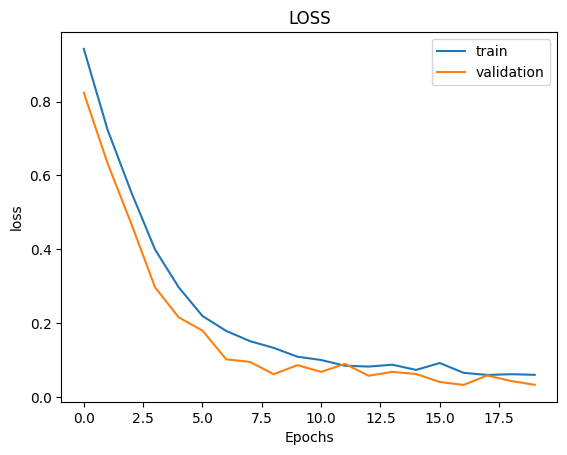

In [122]:
show_metrics(history, "loss")

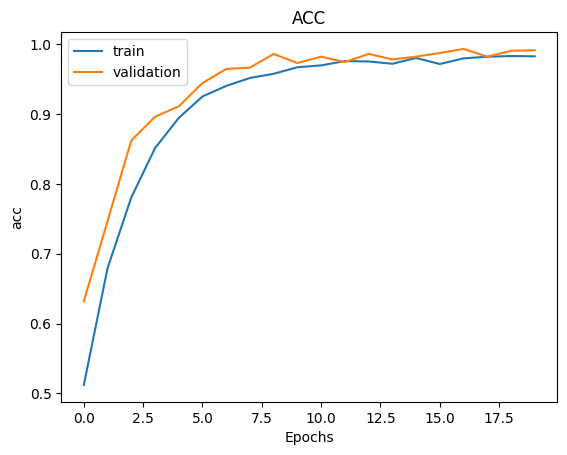

In [123]:
show_metrics(history, "acc")

In [124]:
test_dl = DataLoader(test_data, batch_size=64, generator=torch.Generator(device="cpu"))

In [125]:
def evaluate(model):
    
    t_model = model
    t_model.to(device)
    t_model.eval()
    
    
    loss_fn = nn.CrossEntropyLoss()
    
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad():
        for x, y in tqdm(test_dl):
            x = x.to(device)
            y = y.to(device)
    
            y_preds = t_model(x)
    
            curr_loss = loss_fn(y_preds, y)
            total_loss += curr_loss.item()
    
            preds = torch.argmax(y_preds, dim=1)
    
            curr_acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
            total_acc += curr_acc.item()
    
    losses = total_loss / len(test_dl)
    accuracy = total_acc / len(test_dl)


    print(f"[Loss: {losses}][Accuracy: {accuracy}]")

In [126]:
evaluate(model)

100%|██████████| 24/24 [00:10<00:00,  2.33it/s]

[Loss: 0.042903458777194224][Accuracy: 0.9908854166666666]


In [127]:
tensor = torch.rand(1, 3, 224, 224)
model.predict(tensor)

tensor([0], device='cuda:0')

100%|██████████| 24/24 [00:08<00:00,  2.71it/s]


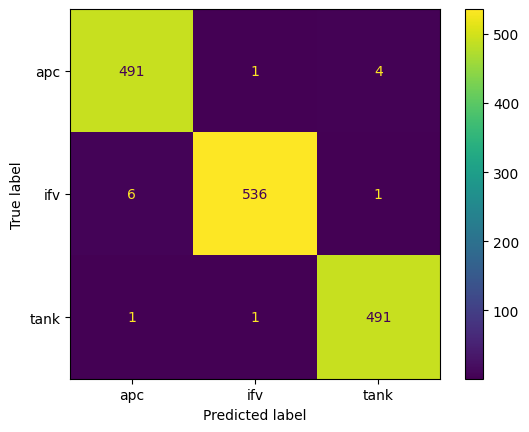

In [128]:
y_true = []
y_preds = []


with torch.no_grad():
    for x, y in tqdm(test_dl):

        x = x.to(device)
        y = y.to(device)
        
        preds = model(x)

        preds = torch.argmax(preds, dim=1)

        y_true.extend(y.cpu().numpy())
        y_preds.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_preds = np.array(y_preds)

ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels = classes)
        

In [129]:
def output_prediction(path, model, classes):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255

    image = torch.tensor(img, dtype = torch.float32)
    image = image.permute(2, 0, 1)

    res = model.predict(image)
    fin_res = classes[int(res)]

    plt.imshow(img)
    plt.title(f"Prediction: {fin_res}")
    plt.show()
    

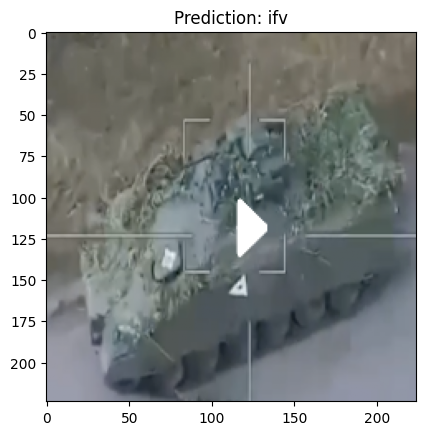

In [130]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/F_293_2309 — копия 4.jpg"
output_prediction(image, model, classes)

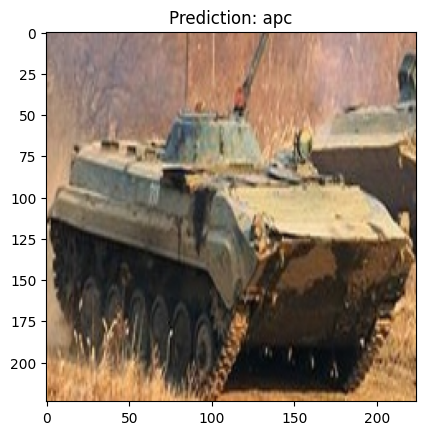

In [131]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/F_3418_612.jpg"
output_prediction(image, model, classes)

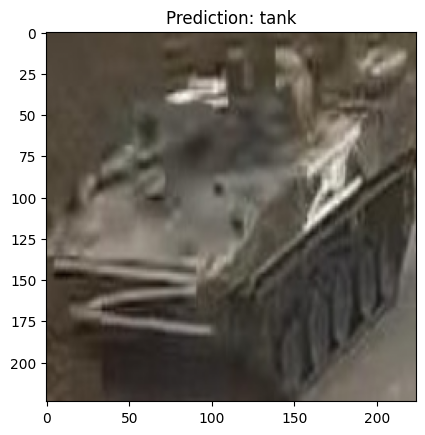

In [132]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/F_504_3977.jpg"
output_prediction(image, model, classes)

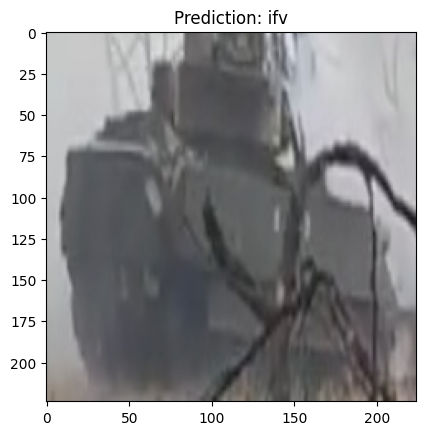

In [133]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/photo_102_4513.jpg"
output_prediction(image, model, classes)

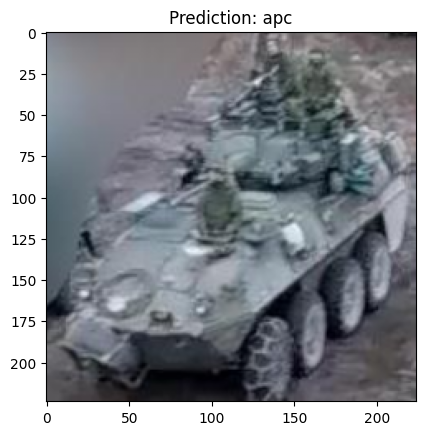

In [134]:
image = "/kaggle/input/apc-tank-ifv/dataset/apc/228_n 3.jpg"
output_prediction(image, model, classes)

In [135]:
torch.save(model.state_dict(), "oko_updated.pt")

In [137]:
t_model = Oko()
t_model.load_state_dict(torch.load("/kaggle/working/oko_updated.pt"))

/tmp/ipykernel_23/804615611.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_model.load_state_dict(torch.load("/kaggle/working/oko_updated.pt"))


<All keys matched successfully>

In [140]:
tensor = torch.rand(1, 3, 224, 224).to(device)
t_model.to(device)

res = t_model.predict(tensor)

res

tensor([0], device='cuda:0')